<a href="https://colab.research.google.com/github/beingmechon/DataAnalysisWithPython/blob/main/HealthData_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data and parsing


## Download data

In [1]:
!git clone https://github.com/mendelson/polar-sample-database.git

Cloning into 'polar-sample-database'...
remote: Enumerating objects: 2149, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 2149 (delta 9), reused 8 (delta 8), pack-reused 2139
Receiving objects: 100% (2149/2149), 82.50 MiB | 20.53 MiB/s, done.
Resolving deltas: 100% (1738/1738), done.
Updating files: 100% (1966/1966), done.


## Import libs

In [2]:
import json
from functools import reduce
from os import listdir
from os.path import isfile, join
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tabulate
from pylab import rcParams
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt
from statsmodels.stats.outliers_influence import variance_inflation_factor

from IPython.display import display, HTML

## Setup

In [3]:
rcParams['figure.figsize'] = (4, 4)
Path('img').mkdir(parents=True, exist_ok=True)
pd.options.display.float_format = "{:,.2f}".format

## Data Parsing

In [4]:
path = '/content/polar-sample-database/dataset'

files = [f for f in listdir(path) if isfile(join(path, f)) and 'training-session' in f]

In [5]:
len(files)

1183

In [6]:
data = []

for f in files:
    with open(join(path, f)) as f:
        d = json.load(f)
        data.append(d)

In [7]:
quantiles = [0.01, 0.25, 0.5, 0.75, 0.99]

In [8]:
def extract_hr_info(workout, quantiles):
    stats = {
        'heartRateAvg2': np.nan,
        'heartRateStd': np.nan,
        'heartRateMax': np.nan,
        'heartRateMin': np.nan,
        'heartRateAvg': np.nan
    }

    for q in quantiles:
        stats[f'heartRateQ{int(q * 100)}'] = np.nan

    # Check if data exists
    try:
        heart_rates = [hr['value'] for hr in workout.get('exercises', [])[0].get('samples', {}).get('heartRate', []) if 'value' in hr]
    except KeyError:
        return stats

    # Check if heart_rates is not empty
    if heart_rates:
        hr_data = np.array(heart_rates)
        stats['heartRateMax'] = np.nanmax(hr_data)
        stats['heartRateMin'] = np.nanmin(hr_data)
        stats['heartRateAvg'] = np.nanmean(hr_data)
        stats['heartRateStd'] = np.nanstd(hr_data)
        stats['heartRateAvg2'] = np.nanmean(hr_data)

        for q in quantiles:
            stats[f'heartRateQ{int(q * 100)}'] = np.nanquantile(hr_data, q)

    return stats


In [9]:
workouts = [
    {**d['exercises'][0], **extract_hr_info(workout=d, quantiles=quantiles)}
    for d in data
]

In [10]:
len(workouts)

1183

## Create dataframe

In [11]:
df = pd.DataFrame(workouts)

In [12]:
df.head()

,startTime,stopTime,timezoneOffset,distance,sport,latitude,longitude,kiloCalories,cadence,zones,...,heartRateStd,heartRateMax,heartRateMin,heartRateAvg,heartRateQ1,heartRateQ25,heartRateQ50,heartRateQ75,heartRateQ99,swimming
0,2021-03-26T14:59:47.793,2021-03-26T15:40:29.045,-180.00,"6,932.90",RUNNING,-15.83,-47.98,460.00,"{'avg': 89, 'max': 93}","{'heart_rate': [{'lowerLimit': 124, 'higherLim...",...,11.46,172.00,64.00,130.35,78.00,126.00,133.00,136.00,163.60,NaN
1,2015-09-17T11:02:19.000,2015-09-17T11:13:59.875,-180.00,928.00,WALKING,-15.79,-47.90,141.00,NaN,"{'heart_rate': [{'lowerLimit': 99, 'higherLimi...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-13T19:25:48.000,2019-11-13T19:50:35.452,-180.00,"3,000.00",TREADMILL_RUNNING,NaN,NaN,276.00,NaN,"{'heart_rate': [{'lowerLimit': 97, 'higherLimi...",...,19.56,164.00,78.00,135.77,86.86,120.00,138.00,153.00,163.00,NaN
3,2016-02-12T12:11:32.000,2016-02-12T13:01:30.750,-180.00,NaN,POOL_SWIMMING,NaN,NaN,395.00,NaN,{},...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-08T19:51:22.055,2021-02-08T20:25:49.183,-180.00,"6,011.90",RUNNING,-15.83,-47.98,462.00,"{'avg': 91, 'max': 97}","{'heart_rate': [{'lowerLimit': 97, 'higherLimi...",...,16.22,184.00,96.00,144.20,102.66,135.00,140.00,143.00,183.00,NaN


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1183 entries, 0 to 1182
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   startTime       1183 non-null   object 
 1   stopTime        1183 non-null   object 
 2   timezoneOffset  1164 non-null   float64
 3   distance        663 non-null    float64
 4   sport           1183 non-null   object 
 5   latitude        429 non-null    float64
 6   longitude       429 non-null    float64
 7   kiloCalories    1162 non-null   float64
 8   cadence         388 non-null    object 
 9   zones           1183 non-null   object 
 10  samples         1183 non-null   object 
 11  heartRateAvg2   903 non-null    float64
 12  heartRateStd    903 non-null    float64
 13  heartRateMax    903 non-null    float64
 14  heartRateMin    903 non-null    float64
 15  heartRateAvg    903 non-null    float64
 16  heartRateQ1     903 non-null    float64
 17  heartRateQ25    903 non-null    f

In [14]:
df.columns

Index(['startTime', 'stopTime', 'timezoneOffset', 'distance', 'sport',
       'latitude', 'longitude', 'kiloCalories', 'cadence', 'zones', 'samples',
       'heartRateAvg2', 'heartRateStd', 'heartRateMax', 'heartRateMin',
       'heartRateAvg', 'heartRateQ1', 'heartRateQ25', 'heartRateQ50',
       'heartRateQ75', 'heartRateQ99', 'swimming'],
      dtype='object')

In [15]:
# Drop unwanted columns

df = df.drop(['zones', 'samples', 'latitude', 'longitude', 'swimming', 'cadence'], axis=1)

In [16]:
df.head()

,startTime,stopTime,timezoneOffset,distance,sport,kiloCalories,heartRateAvg2,heartRateStd,heartRateMax,heartRateMin,heartRateAvg,heartRateQ1,heartRateQ25,heartRateQ50,heartRateQ75,heartRateQ99
0,2021-03-26T14:59:47.793,2021-03-26T15:40:29.045,-180.00,"6,932.90",RUNNING,460.00,130.35,11.46,172.00,64.00,130.35,78.00,126.00,133.00,136.00,163.60
1,2015-09-17T11:02:19.000,2015-09-17T11:13:59.875,-180.00,928.00,WALKING,141.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-11-13T19:25:48.000,2019-11-13T19:50:35.452,-180.00,"3,000.00",TREADMILL_RUNNING,276.00,135.77,19.56,164.00,78.00,135.77,86.86,120.00,138.00,153.00,163.00
3,2016-02-12T12:11:32.000,2016-02-12T13:01:30.750,-180.00,NaN,POOL_SWIMMING,395.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-08T19:51:22.055,2021-02-08T20:25:49.183,-180.00,"6,011.90",RUNNING,462.00,144.20,16.22,184.00,96.00,144.20,102.66,135.00,140.00,143.00,183.00


# Data Processing and Transformation

In [17]:
missing = df.isna().sum() / df.shape[0] * 100
missing.name = "Percent missing"
missing = missing[missing > 0].sort_values(ascending=False).reset_index()
missing.rename(columns={'index': 'Feature'}, inplace=True)
missing = missing.round(2)

missing

,Feature,Percent missing
0,distance,43.96
1,heartRateAvg2,23.67
2,heartRateStd,23.67
3,heartRateMax,23.67
4,heartRateMin,23.67
5,heartRateAvg,23.67
6,heartRateQ1,23.67
7,heartRateQ25,23.67
8,heartRateQ50,23.67
9,heartRateQ75,23.67


## Transform date

In [18]:
df['startTime'] = pd.to_datetime(df.startTime)
df['stopTime'] = pd.to_datetime(df.stopTime)

df.startTime.dtype, df.stopTime.dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

In [19]:
df['totalTime'] = df.stopTime - df.startTime
df.totalTime = df.totalTime.apply(lambda x: round(x.seconds/60, 2))

df.head()

,startTime,stopTime,timezoneOffset,distance,sport,kiloCalories,heartRateAvg2,heartRateStd,heartRateMax,heartRateMin,heartRateAvg,heartRateQ1,heartRateQ25,heartRateQ50,heartRateQ75,heartRateQ99,totalTime
0,2021-03-26 14:59:47.793,2021-03-26 15:40:29.045,-180.00,"6,932.90",RUNNING,460.00,130.35,11.46,172.00,64.00,130.35,78.00,126.00,133.00,136.00,163.60,40.68
1,2015-09-17 11:02:19.000,2015-09-17 11:13:59.875,-180.00,928.00,WALKING,141.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.67
2,2019-11-13 19:25:48.000,2019-11-13 19:50:35.452,-180.00,"3,000.00",TREADMILL_RUNNING,276.00,135.77,19.56,164.00,78.00,135.77,86.86,120.00,138.00,153.00,163.00,24.78
3,2016-02-12 12:11:32.000,2016-02-12 13:01:30.750,-180.00,NaN,POOL_SWIMMING,395.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.97
4,2021-02-08 19:51:22.055,2021-02-08 20:25:49.183,-180.00,"6,011.90",RUNNING,462.00,144.20,16.22,184.00,96.00,144.20,102.66,135.00,140.00,143.00,183.00,34.45


## Transform other data

In [20]:
df.isInside = df.distance.apply(lambda x: True if pd.isnull(x) else False)

df = df.drop(['distance'], axis=1)

<ipython-input-20-bd7d81c15491>:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.isInside = df.distance.apply(lambda x: True if pd.isnull(x) else False)


In [21]:
df["isStrength"] = df.sport.apply(lambda x: True if "strength" in x.lower() else False)

In [22]:
df['sport'] = pd.Categorical(df.sport.apply(lambda x: x.lower()))

In [23]:
sports = sorted(list(df['sport'].unique()))
sports

['cycling',
 'functional_training',
 'futsal',
 'mobility_dynamic',
 'mobility_static',
 'open_water_swimming',
 'other_indoor',
 'other_outdoor',
 'pool_swimming',
 'running',
 'spinning',
 'strength_training',
 'swimming',
 'treadmill_running',
 'walking']

In [24]:
order = sorted(df.columns.to_list())
order

['heartRateAvg',
 'heartRateAvg2',
 'heartRateMax',
 'heartRateMin',
 'heartRateQ1',
 'heartRateQ25',
 'heartRateQ50',
 'heartRateQ75',
 'heartRateQ99',
 'heartRateStd',
 'isStrength',
 'kiloCalories',
 'sport',
 'startTime',
 'stopTime',
 'timezoneOffset',
 'totalTime']

In [25]:
df = df[order]


In [26]:
df = df.dropna()

In [27]:
df.isna().sum()


heartRateAvg      0
heartRateAvg2     0
heartRateMax      0
heartRateMin      0
heartRateQ1       0
heartRateQ25      0
heartRateQ50      0
heartRateQ75      0
heartRateQ99      0
heartRateStd      0
isStrength        0
kiloCalories      0
sport             0
startTime         0
stopTime          0
timezoneOffset    0
totalTime         0
dtype: int64

In [28]:
sort_cols = ["startTime", "stopTime"]

df = df.sort_values(sort_cols, ascending=False)
df = df.reset_index(drop=True)

df.head()

,heartRateAvg,heartRateAvg2,heartRateMax,heartRateMin,heartRateQ1,heartRateQ25,heartRateQ50,heartRateQ75,heartRateQ99,heartRateStd,isStrength,kiloCalories,sport,startTime,stopTime,timezoneOffset,totalTime
0,145.23,145.23,171.00,102.00,131.00,139.00,147.00,150.00,166.00,7.86,False,854.00,running,2022-03-19 19:12:49.463,2022-03-19 20:08:21.089,-180.00,55.52
1,116.40,116.40,171.00,76.00,84.00,105.00,114.00,123.00,164.00,18.31,False,705.00,running,2022-03-16 20:16:00.118,2022-03-16 21:22:48.495,-180.00,66.80
2,132.29,132.29,169.00,65.00,110.00,124.00,134.00,139.00,166.00,11.82,False,761.00,running,2022-03-15 19:14:43.304,2022-03-15 20:14:04.682,-180.00,59.35
3,80.95,80.95,112.00,49.00,55.00,71.00,80.00,92.00,108.00,13.40,True,184.00,strength_training,2022-03-14 20:20:40.436,2022-03-14 21:06:20.937,-180.00,45.67
4,65.05,65.05,114.00,45.00,50.00,59.00,64.00,70.00,92.00,9.18,True,228.00,strength_training,2022-03-12 17:05:51.494,2022-03-12 18:32:49.871,-180.00,86.97


In [29]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   heartRateAvg    899 non-null    float64       
 1   heartRateAvg2   899 non-null    float64       
 2   heartRateMax    899 non-null    float64       
 3   heartRateMin    899 non-null    float64       
 4   heartRateQ1     899 non-null    float64       
 5   heartRateQ25    899 non-null    float64       
 6   heartRateQ50    899 non-null    float64       
 7   heartRateQ75    899 non-null    float64       
 8   heartRateQ99    899 non-null    float64       
 9   heartRateStd    899 non-null    float64       
 10  isStrength      899 non-null    bool          
 11  kiloCalories    899 non-null    float64       
 12  sport           899 non-null    category      
 13  startTime       899 non-null    datetime64[ns]
 14  stopTime        899 non-null    datetime64[ns]
 15  timezo

# Data analysis

In [30]:
print(f"First workout date: ", str(df['startTime'].min()))
print(f"Last workout date: ", str(df['startTime'].max()))
print(f"Total workouts: ", len(df))

First workout date:  2015-06-21 15:26:00
Last workout date:  2022-03-19 19:12:49.463000
Total workouts:  899


## Descriptive Statistics



In [31]:
df.drop('timezoneOffset', axis=1).describe()


,heartRateAvg,heartRateAvg2,heartRateMax,heartRateMin,heartRateQ1,heartRateQ25,heartRateQ50,heartRateQ75,heartRateQ99,heartRateStd,kiloCalories,totalTime
count,899.00,899.00,899.00,899.00,899.00,899.00,899.00,899.00,899.00,899.00,899.00,899.00
mean,113.52,113.52,141.95,72.80,83.90,106.61,113.95,121.04,137.78,11.69,414.40,48.21
std,23.14,23.14,25.27,13.60,16.74,23.90,24.43,24.28,24.77,4.51,350.06,27.16
min,25.75,25.75,32.00,0.00,0.00,0.00,0.00,29.00,32.00,3.57,1.00,1.70
25%,92.82,92.82,121.00,64.00,72.00,86.00,92.00,99.00,117.58,8.59,152.00,31.61
50%,114.56,114.56,140.00,71.00,83.89,107.00,115.00,121.00,137.00,10.96,321.00,42.27
75%,131.40,131.40,160.00,80.00,95.00,125.00,133.00,140.00,156.00,13.64,560.00,59.75
max,178.18,178.18,234.00,148.00,157.77,177.00,179.00,182.00,221.28,42.45,"2,830.00",294.40


## Analytical Statistics

### Kilocalories burned in total

In [32]:
total_calories = df['kiloCalories'].sum()

print("Total Calories burned: ", total_calories)

Total Calories burned:  372545.0


In [33]:
def kcal_to_kg(kcal):
  return round(kcal/7700, 2)

In [34]:
kcal_to_kg(total_calories)

48.38

### Kilocalories burned by sport

In [35]:
kcalbySports = df.groupby(['sport'])["kiloCalories"].sum().reset_index().rename(columns={"kiloCalories": "Total KiloCalories", "sport": "Sport"})
kcalbySports["Total Kilograms"] = kcalbySports['Total KiloCalories'].apply(kcal_to_kg)
kcalbySports = kcalbySports.sort_values("Total Kilograms", ascending=False)

kcalbySports

,Sport,Total KiloCalories,Total Kilograms
9,running,"233,431.00",30.32
11,strength_training,"66,383.00",8.62
0,cycling,"23,437.00",3.04
8,pool_swimming,"22,506.00",2.92
13,treadmill_running,"13,177.00",1.71
10,spinning,"9,309.00",1.21
1,functional_training,"2,471.00",0.32
2,futsal,"1,055.00",0.14
14,walking,509.00,0.07
3,mobility_dynamic,145.00,0.02


### Kilocalories burned over time

In [36]:
# 2015-06-21 15:26:00
# 2022-03-19 19:12:49.463000

start = pd.to_datetime('2016-07-1')
stop = pd.to_datetime('2017-04-1')

mask = (df['startTime'] >= start) & (df['startTime'] < stop)
daily = df.loc[mask, ['startTime', 'kiloCalories']]
daily['startTime'] = daily['startTime'].dt.date
daily = daily.groupby('startTime', as_index=False).sum().sort_values('startTime', ascending=False)
daily['startTime'] = pd.to_datetime(daily['startTime'])
daily.reset_index(drop=True, inplace=True)

daily


,startTime,kiloCalories
0,2017-03-30,596.00
1,2017-03-28,110.00
2,2017-03-27,305.00
3,2017-03-19,793.00
4,2017-03-17,52.00
5,2017-01-31,284.00
6,2017-01-18,142.00
7,2017-01-16,185.00
8,2017-01-14,861.00
9,2017-01-12,305.00


In [37]:
dates = pd.date_range(start, stop)
dates = dates.to_frame()
dates = dates.reset_index(drop=True)
dates.columns = ['startTime']

dates

,startTime
0,2016-07-01
1,2016-07-02
2,2016-07-03
3,2016-07-04
4,2016-07-05
...,...
270,2017-03-28
271,2017-03-29
272,2017-03-30
273,2017-03-31


In [38]:
daily = pd.merge(dates, daily, on='startTime', how='left')
daily = daily.fillna(0)

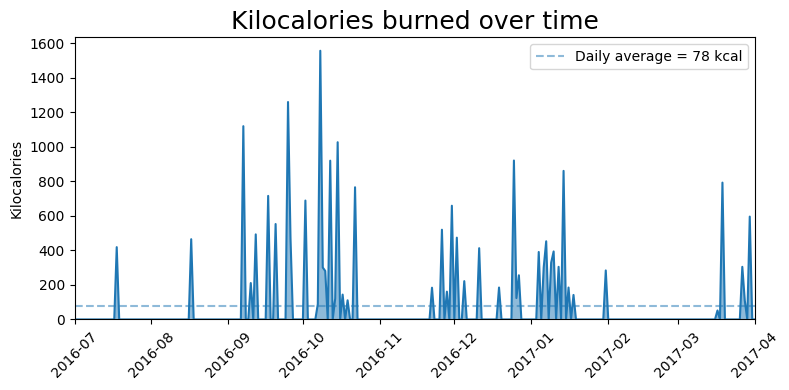

In [39]:
width = 800
height = 400
dpi = 100

plt.figure(figsize=(width/dpi, height/dpi))
plt.plot(daily['startTime'], daily['kiloCalories'])

plt.fill_between(x=daily['startTime'],
                 y1=0,
                 y2=daily['kiloCalories'],
                 alpha=1/2)

daily_avg = daily['kiloCalories'].mean()

plt.hlines(xmin=daily['startTime'].min(),
           xmax=daily['startTime'].max(),
           y=daily_avg,
           linestyle='dashed',
           label=f'Daily average = {round(daily_avg)} kcal',
           alpha=1/2)

plt.title('Kilocalories burned over time', fontsize=18)
plt.xticks(rotation=45, horizontalalignment='center')
plt.xlim(daily['startTime'].min(), daily['startTime'].max())
plt.ylim(0, daily['kiloCalories'].max() * 1.05)
plt.ylabel('Kilocalories')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Heart Rate Quantiles vs. Kilocalories


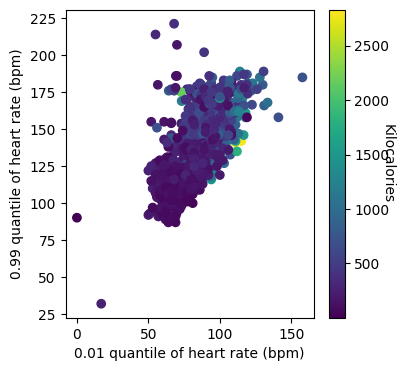

In [40]:
plt.scatter(df['heartRateQ1'], df['heartRateQ99'], c=df['kiloCalories'])
plt.xlabel('0.01 quantile of heart rate (bpm)')
plt.ylabel('0.99 quantile of heart rate (bpm)')

cbar = plt.colorbar()
cbar.set_label('Kilocalories', rotation=270)
plt.show()

### General stats for workout

In [41]:
stats = df[['sport', 'startTime']]
stats = stats.groupby(['sport'], as_index=False)
stats = stats.count()
stats = stats.rename(columns={'sport': 'Sport',
                              'startTime': 'Count'})
stats = stats.sort_values('Count', ascending=False)

stats = stats.style.background_gradient(cmap='YlGn', subset='Count')
stats = stats.set_precision(2)

stats

<ipython-input-41-02fce575f369>:9: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  stats = stats.set_precision(2)


,Sport,Count
11,strength_training,397
9,running,331
8,pool_swimming,51
13,treadmill_running,48
0,cycling,34
10,spinning,25
1,functional_training,7
3,mobility_dynamic,2
4,mobility_static,2
2,futsal,1


### Workout count on hours in day

In [42]:
workout_by_hour = df[['startTime', 'sport']].copy()
workout_by_hour['startHour'] = workout_by_hour['startTime'].dt.hour
workout_by_hour = workout_by_hour.drop('startTime', axis=1)
workout_by_hour = workout_by_hour.groupby('startHour', as_index=False)
workout_by_hour = workout_by_hour.count()

all_hours = pd.DataFrame(range(0, 24), columns=['startHour'])

workout_by_hour = pd.merge(all_hours, workout_by_hour, how='left')
workout_by_hour = workout_by_hour.fillna(0)
workout_by_hour = workout_by_hour.sort_values('startHour')
workout_by_hour = workout_by_hour.rename(columns={'startHour': 'Hour of day',
                                 'sport': 'Total workouts'})

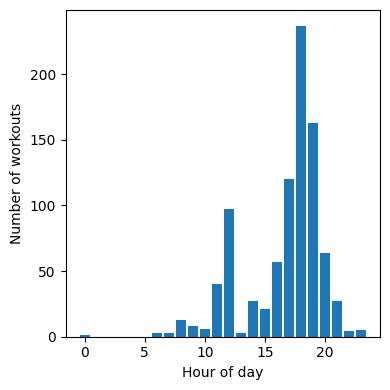

In [43]:
plt.bar(workout_by_hour['Hour of day'], workout_by_hour['Total workouts'])
plt.ylabel('Number of workouts')
plt.xlabel('Hour of day')
plt.tight_layout()
plt.show()

### Kilocalories spend by week day

In [44]:
kcal_by_day = df[['startTime', 'kiloCalories']].copy()
kcal_by_day['Day of week'] = pd.to_datetime(kcal_by_day['startTime']).dt.day_name()
kcal_by_day['Day number'] = pd.to_datetime(kcal_by_day['startTime']).dt.dayofweek
kcal_by_day = kcal_by_day.groupby(['Day of week', 'Day number'], as_index=False).sum('kiloCalories')
kcal_by_day = kcal_by_day.sort_values('Day number')
kcal_by_day = kcal_by_day.rename(columns={'kiloCalories': 'Total Calories'})

kcal_by_day

,Day of week,Day number,Total Calories
1,Monday,0,"69,034.00"
5,Tuesday,1,"43,542.00"
6,Wednesday,2,"68,871.00"
4,Thursday,3,"35,557.00"
0,Friday,4,"60,018.00"
2,Saturday,5,"64,070.00"
3,Sunday,6,"31,453.00"


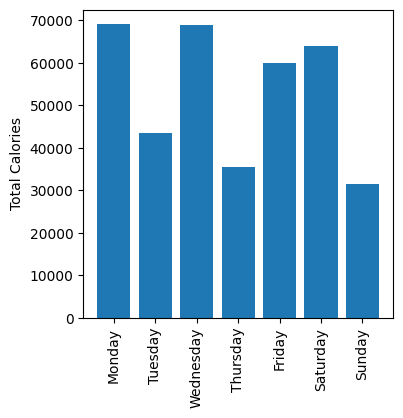

In [45]:
plt.bar(kcal_by_day['Day of week'], kcal_by_day['Total Calories'])
plt.xticks(rotation=90)
plt.ylabel('Total Calories')
plt.show()

### Total workout by week day

In [46]:
by_day = df[['startTime', 'sport']].copy()
by_day['Day of week'] = pd.to_datetime(by_day['startTime']).dt.day_name()
by_day['Day number'] = pd.to_datetime(by_day['startTime']).dt.dayofweek
by_day = by_day.groupby(['Day of week', 'Day number'], as_index=False)
by_day = by_day.count()
by_day = by_day.drop('startTime', axis=1)
by_day = by_day.sort_values('Day number')
by_day = by_day.rename(columns={'sport': 'Total Workouts'})

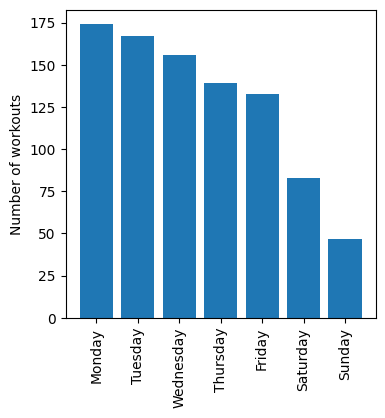

In [47]:
plt.bar(by_day['Day of week'], by_day['Total Workouts'])
plt.xticks(rotation=90)
plt.ylabel('Number of workouts')
plt.show()

### Total time spend vs KiloCalories consumed

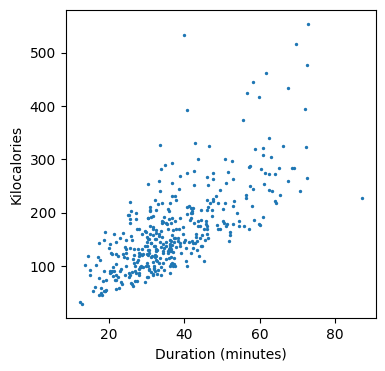

In [48]:
strength_training = df[df['sport'] == 'strength_training']
plt.scatter(strength_training['totalTime'], strength_training['kiloCalories'], s=2)
plt.xlabel('Duration (minutes)')
plt.ylabel('Kilocalories')
plt.show()

### Average Heart rate vs KiloCalories consumed

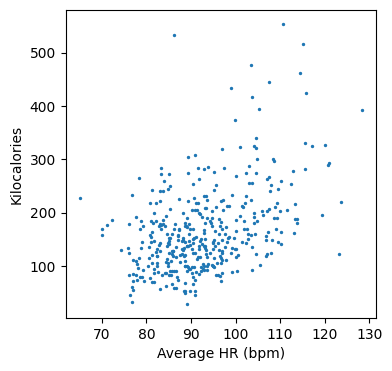

In [49]:
strength_training = df[df['sport'] == 'strength_training']
plt.scatter(strength_training['heartRateAvg'], strength_training['kiloCalories'], s=2)
plt.ylabel('Kilocalories')
plt.xlabel('Average HR (bpm)')
plt.show()

## Inferential Statistical

In [50]:
reg_df = df[['kiloCalories', 'totalTime',
             'heartRateQ99', 'isStrength', 'sport']].copy()

In [51]:
reg_df.sport.value_counts()

strength_training      397
running                331
pool_swimming           51
treadmill_running       48
cycling                 34
spinning                25
functional_training      7
mobility_dynamic         2
mobility_static          2
futsal                   1
walking                  1
open_water_swimming      0
other_indoor             0
other_outdoor            0
swimming                 0
Name: sport, dtype: int64

In [52]:
# Drop columns with very few occurance

drop_values = ['swimming', 'running', 'other_outdoor', 'other_indoor',
             'open_water_swimming', 'walking', 'futsal', 'mobility_static',
             'mobility_dynamic', 'functional_training']

In [53]:
reg_df = reg_df[~reg_df.sport.isin(drop_values)]

In [54]:
reg_df.head()

,kiloCalories,totalTime,heartRateQ99,isStrength,sport
3,184.00,45.67,108.00,True,strength_training
4,228.00,86.97,92.00,True,strength_training
6,120.00,32.33,103.00,True,strength_training
8,204.00,32.68,124.40,True,strength_training
10,133.00,40.42,105.00,True,strength_training


In [55]:
# Check outlier function

def is_outlier_iqr(series, k=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    is_outlier = (series <= q1 - k * iqr) | (q3 + k * iqr <= series)

    return is_outlier

In [56]:
time_mask = is_outlier_iqr(series=reg_df['totalTime'])
kcal_mask = is_outlier_iqr(series=reg_df['kiloCalories'])
hr_mask = is_outlier_iqr(series=reg_df['heartRateQ99'])

In [57]:
# Remove outliters
reg_df_no_outlier = reg_df[~(time_mask | kcal_mask | hr_mask)]

### Histograms

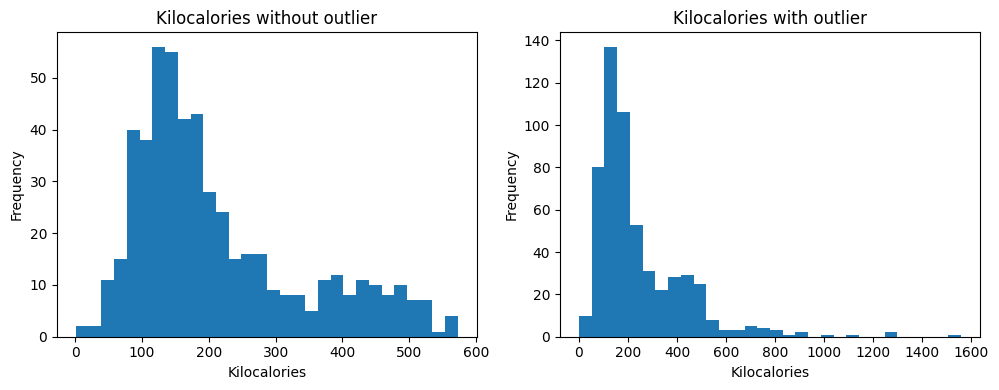

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].hist(reg_df_no_outlier['kiloCalories'], bins=30)
ax[1].hist(reg_df['kiloCalories'], bins=30)
ax[0].set_xlabel('Kilocalories')
ax[0].set_ylabel('Frequency')
ax[0].set_title("Kilocalories without outlier")
ax[1].set_xlabel('Kilocalories')
ax[1].set_ylabel('Frequency')
ax[1].set_title("Kilocalories with outlier")

plt.tight_layout()
plt.show()

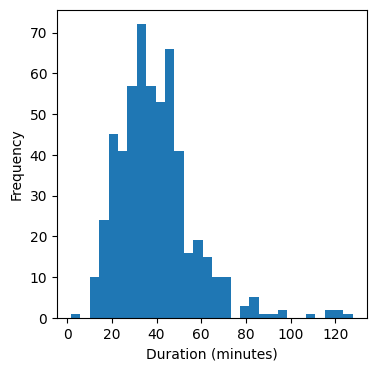

In [59]:
plt.hist(reg_df['totalTime'], bins=30)
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.show()

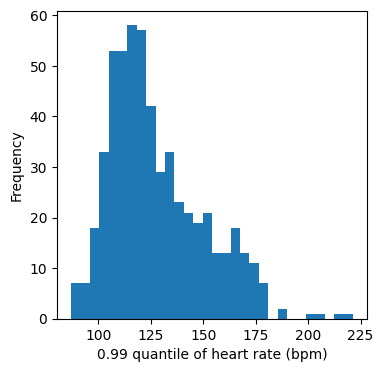

In [60]:
plt.hist(reg_df['heartRateQ99'], bins=30)
plt.xlabel('0.99 quantile of heart rate (bpm)')
plt.ylabel('Frequency')
plt.show()

### Scatter plots

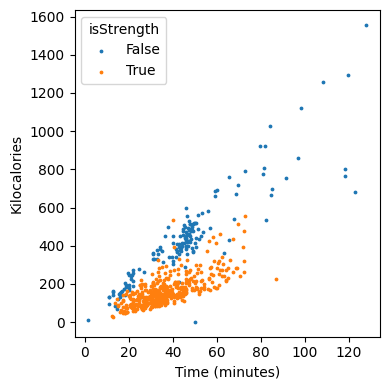

In [61]:
for val in [False, True]:
    tmp = reg_df[reg_df['isStrength'] == val]
    plt.scatter(tmp['totalTime'],
                tmp['kiloCalories'],
                s=3,
                label=val)

plt.xlabel('Time (minutes)')
plt.ylabel('Kilocalories')
plt.legend(title='isStrength', loc='best')
plt.tight_layout()
plt.show()

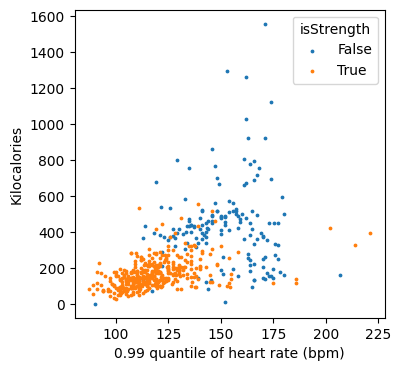

In [62]:
for val in [False, True]:
    tmp = reg_df[reg_df['isStrength'] == val]
    plt.scatter(tmp['heartRateQ99'],
                tmp['kiloCalories'],
                s=3,
                label=val)

plt.xlabel('0.99 quantile of heart rate (bpm)')
plt.ylabel('Kilocalories')
plt.legend(title='isStrength', loc='best')
plt.show()

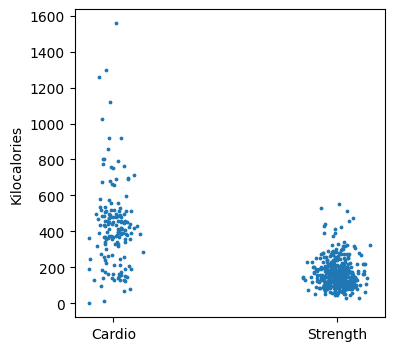

In [63]:
plt.scatter(reg_df['isStrength'] + np.random.normal(scale=1/20, size=len(reg_df)),
            reg_df['kiloCalories'], s=3)

plt.ylabel('Kilocalories')
plt.xticks(ticks=[0, 1], labels=['Cardio', 'Strength'])
plt.show()

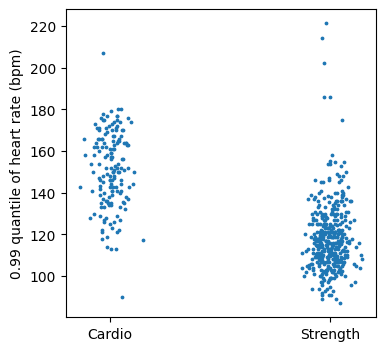

In [64]:
plt.scatter(reg_df['isStrength'] + np.random.normal(scale=1/20, size=len(reg_df)),
            reg_df['heartRateQ99'], s=3)

plt.ylabel('0.99 quantile of heart rate (bpm)')
plt.xticks(ticks=[0, 1], labels=['Cardio', 'Strength'])
plt.show()

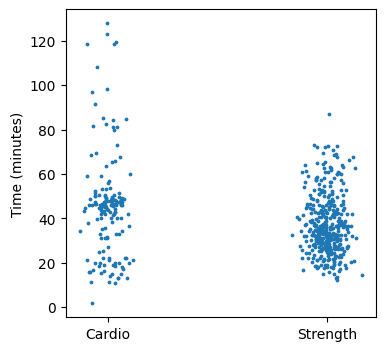

In [65]:
plt.scatter(reg_df['isStrength'] + np.random.normal(scale=1/20, size=len(reg_df)),
            reg_df['totalTime'], s=3)

plt.ylabel('Time (minutes)')
plt.xticks(ticks=[0, 1], labels=['Cardio', 'Strength'])
plt.show()

In [66]:
reg_df['isStrength'] = reg_df['isStrength'].astype(int)

### Correlation between important features

In [67]:
C = reg_df.corr(method='pearson')
C = C.style.background_gradient(cmap='YlGn')
C = C.set_precision(2)
C

<ipython-input-67-4f1d3e2ff84d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  C = reg_df.corr(method='pearson')
<ipython-input-67-4f1d3e2ff84d>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  C = C.set_precision(2)


,kiloCalories,totalTime,heartRateQ99,isStrength
kiloCalories,1.00,0.75,0.55,-0.64
totalTime,0.75,1.00,0.09,-0.22
heartRateQ99,0.55,0.09,1.00,-0.66
isStrength,-0.64,-0.22,-0.66,1.00


### Variance Inflation Factor

In [68]:
tmp = reg_df.drop(['kiloCalories', 'sport'], axis=1)

vifs = []
for i in range(tmp.shape[1]):
    vif = variance_inflation_factor(tmp.to_numpy(), i)
    vifs.append(round(vif, 2))

vifs = pd.DataFrame(vifs, index=tmp.columns, columns=['VIF'])
vifs = vifs.sort_values('VIF', ascending=False)
vifs = vifs.reset_index()
vifs = vifs.rename(columns={'index': 'Variable'})

vifs = vifs.style.background_gradient(cmap='OrRd')
vifs = vifs.set_precision(2)

vifs

<ipython-input-68-1272fa25eba2>:14: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  vifs = vifs.set_precision(2)


,Variable,VIF
0,heartRateQ99,6.81
1,totalTime,5.88
2,isStrength,2.50


### Regression

In [69]:
y_true = reg_df['kiloCalories'].to_numpy()

In [70]:
def calc_rmse(y_true, y_pred):
    x = np.sqrt(np.mean(np.power(y_true - y_pred, 2)))
    return round(x, 4)

In [74]:
formula = 'kiloCalories ~ totalTime'
mdl_time = smf.ols(formula=formula, data=reg_df)
mdl_time = mdl_time.fit()
# mdl_time.summary()
mdl_time.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.568    
Dependent Variable: kiloCalories     AIC:                6917.6172
Date:               2024-03-07 07:55 BIC:                6926.2551
No. Observations:   555              Log-Likelihood:     -3456.8  
Df Model:           1                F-statistic:        728.5    
Df Residuals:       553              Prob (F-statistic): 5.41e-103
R-squared:          0.568            Scale:              15104.   
-------------------------------------------------------------------
            Coef.    Std.Err.     t     P>|t|     [0.025    0.975] 
-------------------------------------------------------------------
Intercept  -82.2186   13.1269  -6.2634  0.0000  -108.0034  -56.4339
totalTime    8.2041    0.3040  26.9905  0.0000     7.6070    8.8011
------------------------------------------------------------------
Omnibus:               50.136       Durbin-Watson:          1.716 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       72.545
Skew:                  0.657        Prob(JB):               0.000 
Kurtosis:              4.187        Condition No.:          109   
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

In [75]:
all_results = []

y_pred = mdl_time.predict(reg_df)
rmse = calc_rmse(y_pred, y_true)
all_results.append((rmse, formula))

print(rmse)

122.6758


In [76]:
all_sports = sorted(reg_df['sport'].unique())
reg_sports_res = []

# For all sport do simple linear regression
for sport in all_sports:
    tmp = reg_df[reg_df['sport'] == sport]
    formula = 'kiloCalories ~ totalTime'
    mdl_sport = smf.ols(formula=formula, data=tmp)
    mdl_sport = mdl_sport.fit()
    sport_stats = [formula, sport] + list(mdl_sport.params) + [mdl_sport.rsquared]
    reg_sports_res.append(sport_stats)

cols = ['Formula', 'Sport', 'Intercept', 'Slope', 'R squared']

reg_sports_res = pd.DataFrame(reg_sports_res, columns=cols)
reg_sports_res = reg_sports_res.sort_values(['Slope'], ascending=False)
reg_sports_res = reg_sports_res.reset_index(drop=True)

readme_df = reg_sports_res.copy().round(2)

# reg_sports_res = reg_sports_res.style.background_gradient(cmap='YlGn', subset='Slope')
# reg_sports_res = reg_sports_res.set_precision(2)

reg_sports_res

,Formula,Sport,Intercept,Slope,R squared
0,kiloCalories ~ totalTime,treadmill_running,-12.03,11.29,0.93
1,kiloCalories ~ totalTime,spinning,-31.92,9.81,0.80
2,kiloCalories ~ totalTime,cycling,-7.30,9.34,0.69
3,kiloCalories ~ totalTime,pool_swimming,7.60,9.11,0.11
4,kiloCalories ~ totalTime,strength_training,2.28,4.43,0.51


In [77]:
formula = 'kiloCalories ~ totalTime + heartRateQ99'
mdl_time_and_hr = smf.ols(formula=formula, data=reg_df)
mdl_time_and_hr = mdl_time_and_hr.fit()
mdl_time_and_hr.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
===================================================================
Model:               OLS              Adj. R-squared:     0.796    
Dependent Variable:  kiloCalories     AIC:                6501.1936
Date:                2024-03-07 07:56 BIC:                6514.1505
No. Observations:    555              Log-Likelihood:     -3247.6  
Df Model:            2                F-statistic:        1083.    
Df Residuals:        552              Prob (F-statistic): 7.85e-192
R-squared:           0.797            Scale:              7119.5   
-------------------------------------------------------------------
               Coef.   Std.Err.    t     P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept    -571.0654  21.5856 -26.4559 0.0000 -613.4653 -528.6655
totalTime       7.7239   0.2096  36.8549 0.0000    7.3123    8.1356
heartRateQ99    3.9733   0.1594  24.9233 0.0000    3.6602    4.2865
-------------------------------------------------------------------
Omnibus:               55.881       Durbin-Watson:          1.345  
Prob(Omnibus):         0.000        Jarque-Bera (JB):       285.234
Skew:                  0.235        Prob(JB):               0.000  
Kurtosis:              6.481        Condition No.:          818    
===================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the errors
is correctly specified.
"""

In [78]:
y_pred = mdl_time_and_hr.predict(reg_df)
rmse = calc_rmse(y_pred, y_true)
all_results.append((rmse, formula))

print(rmse)

84.1488


In [79]:
formula = 'kiloCalories ~ totalTime + heartRateQ99'
re_formula = ' ~ totalTime'
group = 'isStrength'

mdl_time_with_hr_re = smf.mixedlm(formula=formula,
                  data=reg_df,
                  groups=reg_df[group],
                  re_formula=re_formula)

mdl_time_with_hr_re = mdl_time_with_hr_re.fit(method='lbfgs')
mdl_time_with_hr_re.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2706: RuntimeWarning: invalid value encountered in sqrt
  sdf[0:self.k_fe, 1] = np.sqrt(np.diag(self.cov_params()[0:self.k_fe]))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
======================================================================
Model:                MixedLM     Dependent Variable:     kiloCalories
No. Observations:     555         Method:                 REML        
No. Groups:           2           Scale:                  3400.3262   
Min. group size:      158         Log-Likelihood:         -3046.2876  
Max. group size:      397         Converged:              Yes         
Mean group size:      277.5                                           
----------------------------------------------------------------------
                       Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
----------------------------------------------------------------------
Intercept             -346.876   42.054 -8.248 0.000 -429.301 -264.451
totalTime                6.874    2.787  2.467 0.014    1.412   12.337
heartRateQ99             2.604                                        
Group Var             4929.690  112.206                               
Group x totalTime Cov -276.345    7.106                               
totalTime Var           15.491    0.425                               
======================================================================

"""

In [80]:
y_pred = mdl_time_with_hr_re.predict(reg_df)
rmse = calc_rmse(y_pred, y_true)
all_results.append((rmse, formula, re_formula, group))

print(rmse)

92.5769


In [81]:
comp_df = pd.DataFrame(all_results, columns=['RMSE', 'Formula', 'Random effects', 'Groups'])
comp_df = comp_df.sort_values('RMSE')

comp_df = comp_df.style.background_gradient(cmap='OrRd', subset='RMSE')
comp_df = comp_df.set_precision(2)

comp_df

<ipython-input-81-d886221f328f>:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  comp_df = comp_df.set_precision(2)


,RMSE,Formula,Random effects,Groups
1,84.15,kiloCalories ~ totalTime + heartRateQ99,None,None
2,92.58,kiloCalories ~ totalTime + heartRateQ99,~ totalTime,isStrength
0,122.68,kiloCalories ~ totalTime,None,None


In [82]:
mdl = mdl_time_with_hr_re
residuals = mdl_time_with_hr_re.resid

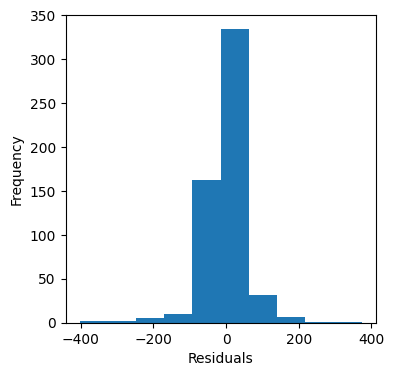

In [83]:
plt.hist(residuals)
plt.ylabel('Frequency')
plt.xlabel('Residuals')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


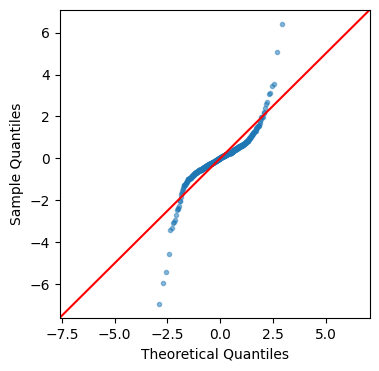

In [84]:
plt.figure()
ax = plt.gca()

qqplot(data=mdl.resid,
       ax=ax,
       color='#1f77b4',
       markersize=3,
       line='45',
       fit=True,
       alpha=1/2)

plt.show()

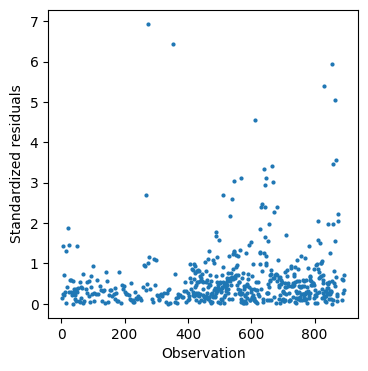

In [85]:
residuals_std = np.abs((residuals - np.mean(residuals)) / np.std(residuals))
plt.plot(residuals_std, 'o', markersize=2)
plt.xlabel('Observation')
plt.ylabel('Standardized residuals')
plt.show()

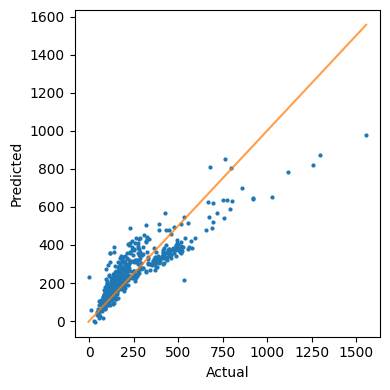

In [86]:
y_pred = mdl.predict(reg_df)
y_pred = y_pred.to_numpy().reshape(len(y_pred))

m = np.min(np.hstack([y_true, y_pred]))
M = np.max(np.hstack([y_true, y_pred]))

x = np.linspace(m, M, len(y_pred))
plt.plot(y_true, y_pred, 'o', markersize=2)
plt.plot(x,x, alpha=3/4)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.tight_layout()
plt.show()

In [87]:
errors = reg_df.copy()
errors['kiloCaloriesPredicted'] = mdl.predict(reg_df)

errors['error'] = np.abs(errors['kiloCalories'] - errors['kiloCaloriesPredicted'])

errors = errors.sort_values('error', ascending=False)
errors = errors.reset_index(drop=True)

order = ['kiloCaloriesPredicted',
         'kiloCalories',
         'error',
         'totalTime',
         'isStrength']

errors = errors[order]

errors = errors.head(5)

errors = errors.style.background_gradient(cmap='OrRd', subset='error')
errors = errors.set_precision(2)

errors

<ipython-input-87-93208414e57b>:20: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  errors = errors.set_precision(2)


,kiloCaloriesPredicted,kiloCalories,error,totalTime,isStrength
0,977.59,1557.00,579.41,127.90,0
1,818.19,1260.00,441.81,108.12,0
2,873.80,1295.00,421.20,119.62,0
3,653.27,1027.00,373.73,84.13,0
4,781.93,1120.00,338.07,98.30,0


In [88]:
print(tabulate.tabulate(kcalbySports.values, kcalbySports.columns, tablefmt="pipe"))

| Sport               |   Total KiloCalories |   Total Kilograms |
|:--------------------|---------------------:|------------------:|
| running             |               233431 |             30.32 |
| strength_training   |                66383 |              8.62 |
| cycling             |                23437 |              3.04 |
| pool_swimming       |                22506 |              2.92 |
| treadmill_running   |                13177 |              1.71 |
| spinning            |                 9309 |              1.21 |
| functional_training |                 2471 |              0.32 |
| futsal              |                 1055 |              0.14 |
| walking             |                  509 |              0.07 |
| mobility_dynamic    |                  145 |              0.02 |
| mobility_static     |                  122 |              0.02 |
| open_water_swimming |                    0 |              0    |
| other_indoor        |                    0 |              0 

In [89]:
print(tabulate.tabulate(readme_df.values, readme_df.columns, tablefmt="pipe"))

| Formula                  | Sport             |   Intercept |   Slope |   R squared |
|:-------------------------|:------------------|------------:|--------:|------------:|
| kiloCalories ~ totalTime | treadmill_running |      -12.03 |   11.29 |        0.93 |
| kiloCalories ~ totalTime | spinning          |      -31.92 |    9.81 |        0.8  |
| kiloCalories ~ totalTime | cycling           |       -7.3  |    9.34 |        0.69 |
| kiloCalories ~ totalTime | pool_swimming     |        7.6  |    9.11 |        0.11 |
| kiloCalories ~ totalTime | strength_training |        2.28 |    4.43 |        0.51 |
